# Exemple d'utilisation de données géologiques

Cet exemple a pour but d'illustrer une utilisation des technologies erddap et python pour aider l'analyse de données géologique.

Dans cet exemple nous allons utiliser une jeu de données présent sur notre serveur erddap et afficher plusieurs variables dans un graphique puit.

ERDDAP (Environmental Research Division's Data Access Program) est une plateforme qui fournit un accès en ligne à de nombreuses données océaniques et environnementales. Il permet aux utilisateurs de rechercher, filtrer et télécharger des ensembles de données à partir de différents serveurs.

Le jeu de données que nous utilisons dans cet exemple contient des mesures géochimiques telles que les teneurs en Ti, Fe et Mn, ainsi que des informations sur la profondeur de chaque mesure.

*Procédure pour y accéder :

**Option 1**
=> se rendre sur https://ogsl.ca/ / Catalogue de données / Jeux de données / Rechercher le jeu de données désiré / Données et ressources

**Option 2**
=> se rendre sur https://erddap.ogsl.ca/erddap/index.html / View a List of All 23 Datasets / choisir le jeu de donné désiré / data
*

L'url suivante nous permet de voir les variables de ce jeu de données et de les filter
https://erddap.ogsl.ca/erddap/tabledap/uqarIsmerCor1502MsclSplit.html

Nous avons:
- Sélectionné sampleId / "COR1502-01PC-BC"
- Ordonné les données par logger_depth
- Sélectionné l'exportation au format CSV.

En cliquant sur "Just generate the URL:", nous obtenons le lien:

https://erddap.ogsl.ca/erddap/tabledap/uqarIsmerCor1502MsclSplit.csv?time%2Clogger_depth%2CTi%2CTi_error%2CV%2CV_error%2CCr%2CCr_error%2CMn%2CMn_error%2CFe%2CFe_error%2Cmunsell_value&sampleID=%22COR1502-01PC-BC%22&orderBy(%22logger_depth%22)

qui va nous servir de base dans cet exemple

In [4]:
import pandas as pd

data_url = "https://erddap.ogsl.ca/erddap/tabledap/uqarIsmerCor1502MsclSplit.csv?time%2Clogger_depth%2CTi%2CTi_error%2CV%2CV_error%2CCr%2CCr_error%2CMn%2CMn_error%2CFe%2CFe_error%2Cmunsell_value&sampleID=%22COR1502-01PC-BC%22&orderBy(%22logger_depth%22)"

dataframe = pd.read_csv(data_url, header=[0,1])
dataframe.head()

,time,logger_depth,Ti,Ti_error,V,V_error,Cr,Cr_error,Mn,Mn_error,Fe,Fe_error,munsell_value
,UTC,m,ppm,ppm,ppm,ppm,ppm,ppm,ppm,ppm,ppm,ppm,unitless
0,2015-06-04T00:00:00Z,0.19,1473.13,103.68,0.0,134.31,0.0,62.26,181.36,19.26,14038.09,128.32,8.4 R 3.40/0.70
1,2015-06-04T00:00:00Z,0.20,1435.43,102.53,0.0,152.57,0.0,67.24,289.77,21.99,22713.16,184.15,4.7 Y 3.80/0.90
2,2015-06-04T00:00:00Z,0.21,1529.10,103.14,0.0,149.53,0.0,68.63,260.77,21.27,22875.39,183.38,4.2 Y 4.40/0.80
3,2015-06-04T00:00:00Z,0.22,1441.67,102.35,0.0,146.48,0.0,69.48,247.05,21.13,23520.62,227.15,4.3 Y 4.30/0.90
4,2015-06-04T00:00:00Z,0.23,1357.09,100.31,0.0,143.97,0.0,67.66,264.95,21.31,24156.54,226.81,4.7 Y 4.00/1.20


Ces données contiennent deux lignes d'en-têtes (nom de variables et unités). Pour faciliter, l'utilisation de plotly nous allons en supprimer une (celle des unités)

In [5]:
dataframe.columns = dataframe.columns.droplevel(-1)

Création d'un graphique composé de 4 graphiques verticaux:
- 3 graphiques affichent des lignes reliant les points de données des teneurs en Ti, Fe et Mn
- 1 graphique affiche la couleur Munsell du relevée

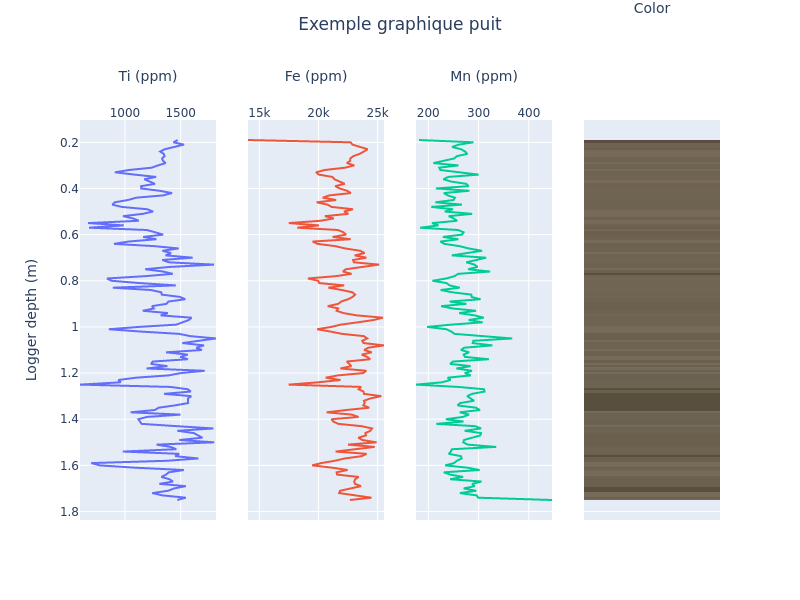

In [6]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import munsell
import re

# Création de l'objet graphique composé
fig = make_subplots(
    rows=1,
    cols=4,
    specs=[[{"type": "xy"}, {"type": "xy"}, {"type": "xy"}, {"type": "bar"}]],
    shared_yaxes=True)

# Création des 3 premiers graphiques
fig.add_trace(
    go.Scatter(
        name="Ti", x=dataframe["Ti"], y=dataframe["logger_depth"], mode="lines", showlegend=False),
    row=1,
    col=1)
fig.update_xaxes(title_text="Ti (ppm)", side="top", row=1, col=1)

fig.add_trace(
    go.Scatter(
        name="Fe", x=dataframe["Fe"], y=dataframe["logger_depth"], mode="lines", showlegend=False),
    row=1,
    col=2)
fig.update_xaxes(title_text="Fe (ppm)", side="top", row=1, col=2)

fig.add_trace(
    go.Scatter(
        name="Mn", x=dataframe["Mn"], y=dataframe["logger_depth"], mode="lines", showlegend=False),
    row=1,
    col=3)
fig.update_xaxes(title_text="Mn (ppm)", side="top", row=1, col=3)

# La création du graphique affichant les couleurs Munsell nécessite un peu d'astuce.
# - Nous allons utiliser un graphique Bar et créer autant de barres que de données.
# - Nous allons faire en sorte que toutes les barres soient consécutives et nous allons interpoler
#  une largeur de barre à partir des points de données
last_max_bound_depth = min(dataframe.logger_depth)

for i in range(len(dataframe)):
    munsell_value = dataframe.loc[i, "munsell_value"]
    current_logger_depth = dataframe.loc[i, "logger_depth"]

    try:
        current_max_bound_depth = (dataframe.loc[i + 1, "logger_depth"] + current_logger_depth) / 2
    except KeyError:
        current_max_bound_depth = dataframe.loc[i, "logger_depth"]

    y_value = [current_max_bound_depth - last_max_bound_depth]
    y_base = [last_max_bound_depth]

    # Plotly ne sais pas afficher le format Munsell, nous allons donc utiliser la librairie
    # https://github.com/samdroid-apps/python-munsell

    munsell_decimals = re.findall("[-+]?(?:\d*\.\d+|\d+)", munsell_value)
    munsell_hues = re.findall("[A-Z]+", munsell_value)

    rgb_color = munsell.MunsellColor(
        munsell_decimals[0] + munsell_hues[0], float(munsell_decimals[1]),
        float(munsell_decimals[2])).to_rgb()

    color_str = f"rgb{rgb_color}"

    fig.add_trace(
        go.Bar(
            name="Color",
            marker=dict(color=color_str, line=dict(width=0, )),
            x=[""],
            y=y_value,
            base=y_base,
            offsetgroup=0,
            showlegend=False,
            customdata=[{"depth": current_logger_depth, "munsell_value": munsell_value}],
            hovertemplate=
            "Logger depth: %{customdata.depth}<br>Munsell value: %{customdata.munsell_value}"),
        row=1,
        col=4)

    fig.update_xaxes(title_text="Color", side="top", row=1, col=4)

    last_max_bound_depth = current_max_bound_depth

fig.update_layout(
    height=600,
    width=800,
    title=dict(text="Exemple graphique puit", x=0.5, y=0.97),
    bargap=0,
    margin=dict(t=120))

fig.update_yaxes(title_text='Logger depth (m)', row=1, col=1, autorange='reversed')

# Remove "png" to display an interactive graph
# Le mode intéractif permet de voir de nombre de profils d'une journée avec le curseur de la souris
fig.show("png")